In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)


from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


In [6]:
wild_fires = pd.read_parquet('/content/wildfire_data.parquet')
wild_fires.head()

,latitude,longitude,datetime,tmmx,vs,fm100,Wildfire,rmax_label
1984675,36.990160,-112.975600,2015-10-13,302.5,1.4,7.6,0,Very Low
1817950,35.553270,-94.667150,2015-07-28,307.8,3.7,15.2,0,High
6154043,33.912960,-118.105400,2017-10-01,298.3,1.8,12.8,1,Moderate
1963711,34.420939,-117.172528,2019-07-04,303.9,4.1,5.0,0,NaN
2296402,41.375214,-122.377645,2015-04-17,297.5,2.6,9.6,0,Very Low


In [7]:
wild_fires.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1464564 entries, 1984675 to 2355671
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   latitude    1464564 non-null  float64       
 1   longitude   1464564 non-null  float64       
 2   datetime    1464564 non-null  datetime64[ns]
 3   tmmx        1464564 non-null  float64       
 4   vs          1464564 non-null  float64       
 5   fm100       1464564 non-null  float64       
 6   Wildfire    1464564 non-null  int64         
 7   rmax_label  1307476 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(5), int64(1)
memory usage: 90.8 MB


In [8]:
# --------------------------
# 1. Sample Data (5% Stratified)
# --------------------------
sampled_df = wild_fires.groupby('Wildfire', group_keys=False).apply(
    lambda x: x.sample(frac=0.05, random_state=42)
).reset_index(drop=True)

print("Sampled dataset shape:", sampled_df.shape)
print(sampled_df['Wildfire'].value_counts())

# --------------------------
# 2. Create a copy for transformation (so original stays untouched)
# --------------------------
df_copy = sampled_df.copy()  # <--- Work on a copy

# --------------------------
# 3. Define y (target)
# --------------------------
y = df_copy['Wildfire']   # safe, no change to original

# --------------------------
# 4. Feature Selection
# --------------------------
features = ['latitude', 'longitude', 'datetime', 'rmax_label', 'tmmx', 'vs', 'fm100']
X_df = df_copy[features].copy()

# Rename features (optional, cosmetic)
X_df = X_df.rename(columns={
    # 'latitude': 'lat',
    # 'longitude': 'lon',
    'datetime': 'date',
    'rmax': 'max_humidity',
    'tmmx': 'max_temp',
    'vs': 'vapor_pressure',
    'fm100': 'fuel_moisture_100h'
})

# Convert date and extract components
X_df['date'] = pd.to_datetime(X_df['date'])
X_df['year'] = X_df['date'].dt.year
X_df['month'] = X_df['date'].dt.month
# X_df['day'] = X_df['date'].dt.day
X_df.drop(columns=['date'], inplace=True)

# --------------------------
# 5. Train-Test Split (only rows where y is not NaN)
# --------------------------
valid_idx = y.dropna().index

x_train, x_val, y_train, y_val = train_test_split(
    X_df, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)
print("Wildfire distribution in training set:\n", y_train.value_counts())
print("Wildfire distribution in validation set:\n", y_val.value_counts())


Sampled dataset shape: (73228, 8)
Wildfire
0    48819
1    24409
Name: count, dtype: int64
Training set shape: (58582, 8)
Validation set shape: (14646, 8)
Wildfire distribution in training set:
 Wildfire
0    39055
1    19527
Name: count, dtype: int64
Wildfire distribution in validation set:
 Wildfire
0    9764
1    4882
Name: count, dtype: int64


/tmp/ipython-input-2066809837.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = wild_fires.groupby('Wildfire', group_keys=False).apply(


In [9]:
# Check cleaned feature DataFrame
X_df.head()

,latitude,longitude,rmax_label,max_temp,vapor_pressure,fuel_moisture_100h,year,month
0,48.270104,-103.745493,High,296.8,2.0,18.0,2023,9
1,45.931330,-122.355000,Low,293.1,3.5,14.2,2021,9
2,41.480830,-106.101300,High,295.6,2.4,14.4,2014,7
3,27.683890,-81.953610,High,306.5,1.8,18.6,2014,7
4,46.947720,-114.676900,Very Low,306.2,3.4,7.3,2015,7


In [10]:
y.head()

,Wildfire
0,0
1,0
2,0
3,0
4,0


In [11]:
X_df.columns

Index(['latitude', 'longitude', 'rmax_label', 'max_temp', 'vapor_pressure',
       'fuel_moisture_100h', 'year', 'month'],
      dtype='object')

In [12]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73228 entries, 0 to 73227
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   latitude            73228 non-null  float64 
 1   longitude           73228 non-null  float64 
 2   rmax_label          65416 non-null  category
 3   max_temp            73228 non-null  float64 
 4   vapor_pressure      73228 non-null  float64 
 5   fuel_moisture_100h  73228 non-null  float64 
 6   year                73228 non-null  int32   
 7   month               73228 non-null  int32   
dtypes: category(1), float64(5), int32(2)
memory usage: 3.4 MB


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score
import joblib
from google.colab import files

# --------------------------
# 1. Define columns
# --------------------------
ordinal_col = "rmax_label"
humidity_order = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

num_features = ['latitude', 'longitude', 'max_temp', 'vapor_pressure',
                'fuel_moisture_100h', 'year', 'month']
cat_features = [ordinal_col]

# --------------------------
# 2. Preprocessing pipelines
# --------------------------
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(categories=[humidity_order]))
])

preprocess = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# --------------------------
# 3. Model pipeline
# --------------------------
pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# --------------------------
# 4. Train Baseline
# --------------------------
pipeline.fit(x_train, y_train)
print("Baseline Accuracy:", pipeline.score(x_val, y_val))

# --------------------------
# 5. Light Grid Search
# --------------------------
search_space_rf = [{
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 20],
    'model__min_samples_split': [2],
    'model__min_samples_leaf': [1],
    'model__max_features': ['sqrt']
}]

gs = GridSearchCV(pipeline, search_space_rf, cv=3, verbose=1, n_jobs=-1)
gs.fit(x_train, y_train)

best_model = gs.best_estimator_
print("\nBest Model:", best_model)
print("Best Model Accuracy:", best_model.score(x_val, y_val))

# --------------------------
# 6. Save Model
# --------------------------
joblib.dump(best_model, "wildfire_rf_best_model.pkl")
print("\nModel saved as wildfire_rf_best_model.pkl")
files.download("wildfire_rf_best_model.pkl")

# --------------------------
# 7. Evaluation
# --------------------------
y_pred = best_model.predict(x_val)
y_proba = best_model.predict_proba(x_val)[:, 1]

print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_proba))


Baseline Accuracy: 0.7242250443807183
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best Model: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'max_temp', 'vapor_pressure',
                                                   'fuel_moisture_100h', 'year',
                                                   'month']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      9764
           1       0.61      0.49      0.55      4882

    accuracy                           0.73     14646
   macro avg       0.69      0.67      0.68     14646
weighted avg       0.72      0.73      0.72     14646

Precision: 0.6147164026571282
Recall: 0.4928308070462925
ROC-AUC: 0.7717606320302104


In [14]:
# import joblib

# rf_model = joblib.load('/content/wildfire_rf_best_model.pkl')
# print(rf_model)

                   Feature  Importance
1           num__longitude    0.184060
0            num__latitude    0.172502
5                num__year    0.153919
2            num__max_temp    0.139221
4  num__fuel_moisture_100h    0.128725
3      num__vapor_pressure    0.112900
6               num__month    0.072477
7          cat__rmax_label    0.036195


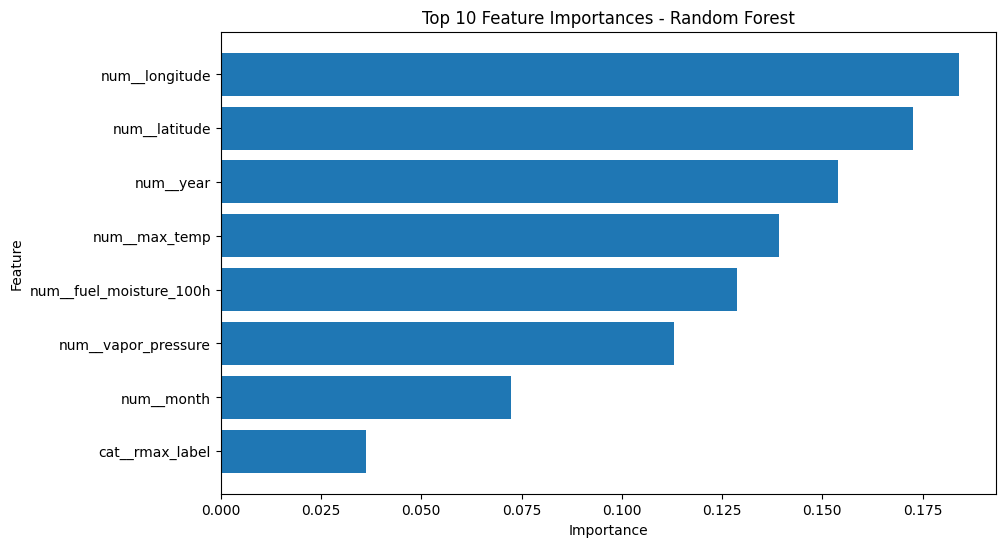

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the Random Forest model from your pipeline
rf_model = best_model.named_steps['model']

# Get feature names from the preprocessor
feature_names = (
    best_model.named_steps['preprocess']
    .get_feature_names_out()
)

# Combine names + importances
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Show table
print(feat_importance_df)

# Plot top 10
plt.figure(figsize=(10,6))
plt.barh(feat_importance_df['Feature'][:10], feat_importance_df['Importance'][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


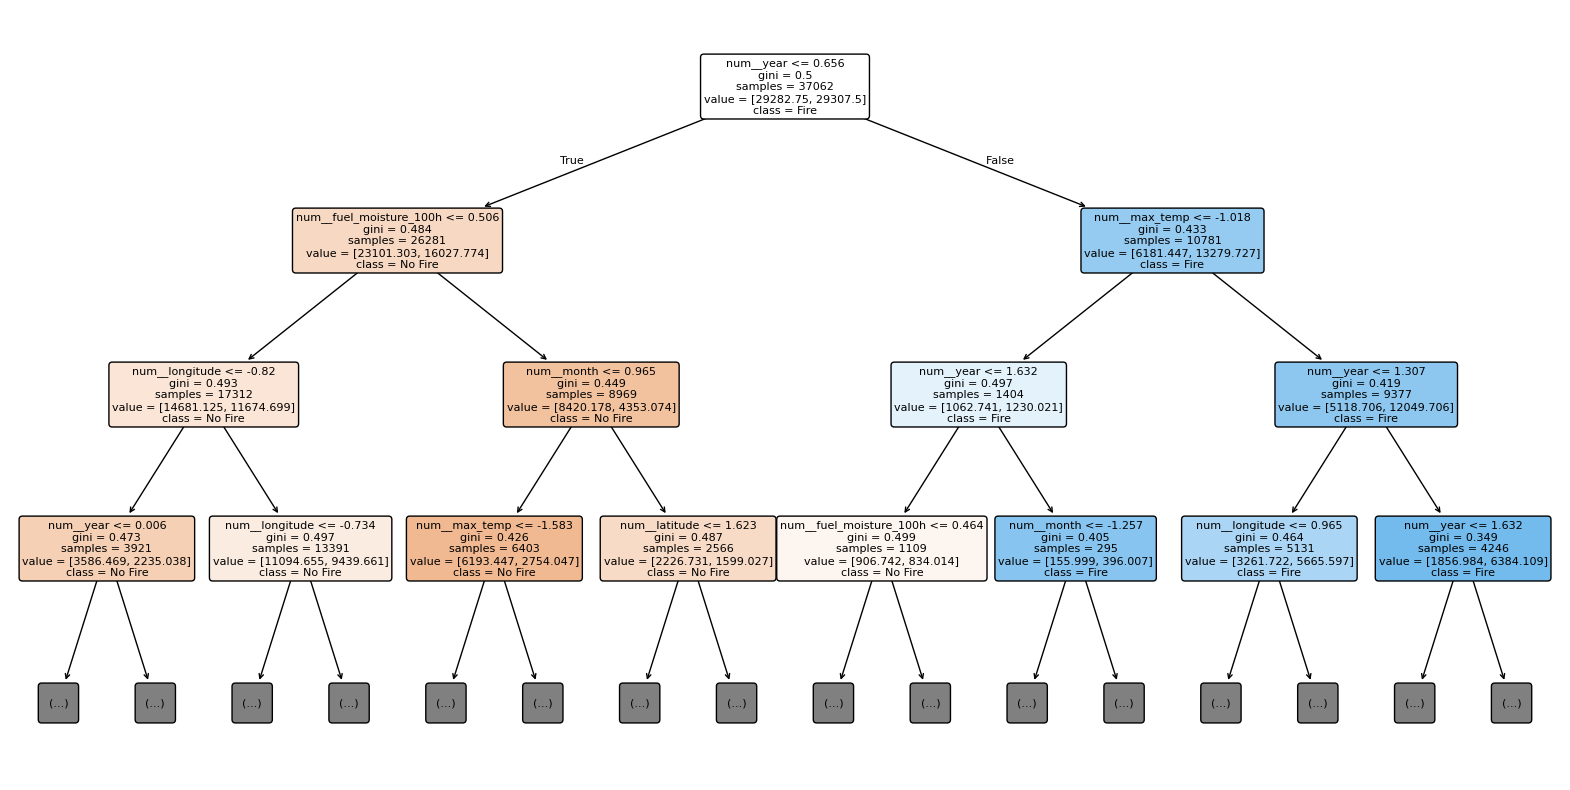

In [16]:
from sklearn.tree import plot_tree

# Select one tree (e.g., first one)
single_tree = rf_model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(
    single_tree,
    feature_names=feature_names,
    class_names=['No Fire', 'Fire'],
    filled=True,
    rounded=True,
    fontsize=8,
    max_depth=3  # Show only top 3 levels for readability
)
plt.show()

In [17]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(
    single_tree,
    feature_names=feature_names,
    class_names=['No Fire', 'Fire'],
    filled=True, rounded=True,
    special_characters=True,
    max_depth=3
)

graph = graphviz.Source(dot_data)
graph.render("random_forest_tree")

'random_forest_tree.pdf'

In [18]:
# # to test a prediction˙

# import pandas as pd
# import numpy as np

# def generate_max_humidity_label(max_humidity):
#     # Define bin edges and labels
#     bin_edges = [45.299, 64.4, 77.3, 87.9, 99.9, 100.0]  # humidity ranges
#     labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

#     # Use pd.cut to assign a label
#     label = pd.cut([max_humidity], bins=bin_edges, labels=labels, include_lowest=True)[0]
#     return label
